## Import packages

In [791]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyod.models.mad import MAD
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer

## Load data

In [792]:
# Columns to exclude
cols_drop = ['amenities', 'calendar_last_scraped', 'calendar_updated', 'description', 'host_about',
             'host_has_profile_pic', 'host_id', 'host_location', 'host_name', 'host_neighbourhood', 
             'host_picture_url', 'host_thumbnail_url', 'host_url', 'id', 'latitude', 'last_scraped',
             'license', 'listing_url', 'longitude', 'name', 'neighborhood_overview', 'neighbourhood', 
             'neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'picture_url', 'scrape_id', 'source']

# Read the CSV file and exclude the specified columns
df = pd.read_csv('listings.csv', usecols=lambda col: col not in cols_drop,
                 parse_dates=['first_review', 'last_review', 'host_since'])

## Turn price into integers

In [793]:
df['price'] = df['price'].str.replace('$','').str.replace(',','').str.replace('.00','').astype(int)

## Turn string rates into floats

In [794]:
df['host_response_rate'] = df['host_response_rate'].str.replace('%','').astype(float)/100
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%','').astype(float)/100

## Get mean of review scores

In [795]:
review_scores = [col for col in df.columns if 'score' in col]
df.loc[:, 'review_scores_mean'] = df.loc[:, review_scores].mean(axis=1)
df.drop(review_scores, axis=1, inplace=True)

## Encode binary features

In [796]:
cols_binary = ['host_is_superhost', 'host_identity_verified','has_availability', 'instant_bookable']

for col in cols_binary:
    # Encode t/f to 1/0 
    df[col] = np.where(df[col] == 't', 1,
                       np.where(df[col] == 'f', 0, np.nan))

    # Check if there are any NA values in the column
    if df[col].isna().any():
        # Convert the column to float if NA values are present
        df[col] = df[col].astype(float)
    else:
        # Convert the column to int8 if there are no NA values
        df[col] = df[col].astype(np.int8)

## Extract floats from bathrooms_text column

In [797]:
# Regular expression pattern to extract float numbers
pattern = r'(\d+(?:\.\d+)?)'
    
df['bathrooms'] = df['bathrooms_text'].str.extract(pattern).astype(float)

# Map remaining text-based values
mapping = {'Shared half-bath': 0.5, 'Half-bath': 0.5, 'Private half-bath': 0.5}
df.loc[df['bathrooms'].isna(), 'bathrooms'] = df.loc[df['bathrooms'].isna(), 'bathrooms_text'].map(mapping)

# Drop bathrooms_text column
df.drop(axis=1, columns=['bathrooms_text'], inplace=True)

## Turn dates into duration periods

In [798]:
# Date columns .to_datetime() and get duration in days until data retrieval
# End date from http://insideairbnb.com for Melbourne, Australia
end_date = datetime.strptime('13-03-2023', '%d-%m-%Y')

# Convert date columns to datetime and calculate the days passed from the end date
date_columns = ['host_since', 'first_review', 'last_review']

for col in date_columns:
    # Convert the column to datetime format
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
    # Calculate the number of days passed from the end date
    df[col] = (end_date - df[col]).dt.days

## Transform categorical features

In [799]:
cols_cat = ['host_response_time', 'host_verifications', 'property_type', 'room_type']
for col in cols_cat:
    df[col] = df[col].astype('category')

## Inspect correlations

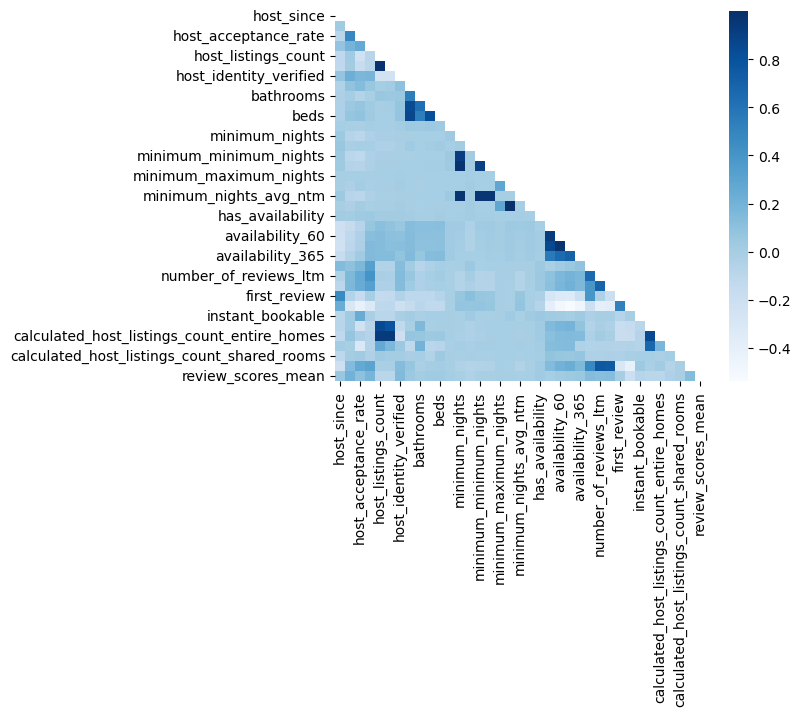

In [800]:
matrix = df.select_dtypes(include=np.number).corr()
mask = np.triu(np.ones_like(matrix, dtype=bool))

sns.heatmap(matrix, square=True, mask=mask, fmt=".2f", cmap='Blues');

In [801]:
df_corr = df.select_dtypes(include=np.number).corr().stack().reset_index()
df_corr = df_corr.rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'correlation'})
df_corr = df_corr[df_corr['feature_1'] != df_corr['feature_2']]

df_corr[df_corr.correlation>0.8]

,feature_1,feature_2,correlation
153,host_listings_count,host_total_listings_count,0.979759
179,host_listings_count,calculated_host_listings_count,0.843922
180,host_listings_count,calculated_host_listings_count_entire_homes,0.929996
189,host_total_listings_count,host_listings_count,0.979759
217,host_total_listings_count,calculated_host_listings_count_entire_homes,0.939651
268,accommodates,bedrooms,0.841339
269,accommodates,beds,0.865045
340,bedrooms,accommodates,0.841339
343,bedrooms,beds,0.818930
377,beds,accommodates,0.865045


## Engineer total capacity feature

In [802]:
df['total_capacity'] = df['accommodates'] + df['beds'] + df['bedrooms']
df.drop(columns=['accommodates', 'beds', 'bedrooms'], inplace=True)

## Drop host listing counts
The features are highly correlated and hold no price relevant information

In [803]:
df.drop(columns=[col for col in df.columns if 'count' in col], inplace=True)

## Drop min/max night features
Features are correlated an hold no valuable information.

In [804]:
df.drop(columns=[col for col in df.columns if 'night' in col], inplace=True)

## Drop availability
Features are correlated and without valuable information

In [805]:
df.drop(columns=[col for col in df.columns if 'availability' in col], inplace=True)

## Drop review counts

In [806]:
df.drop(columns=['number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review',
                 'reviews_per_month'], inplace=True)

After dropping many highly correlated features and constructing some new ones, we are left with only 15 features in the dataset. The correlations between most features are now below 0.5.

In [807]:
df_corr = df.select_dtypes(include=np.number).corr().stack().reset_index()
df_corr = df_corr.rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'correlation'})
df_corr = df_corr[df_corr['feature_1'] != df_corr['feature_2']]

df_corr.sort_values(by='correlation', ascending=False).head(5)

,feature_1,feature_2,correlation
65,bathrooms,total_capacity,0.584274
115,total_capacity,bathrooms,0.584274
23,host_acceptance_rate,host_response_rate,0.484324
13,host_response_rate,host_acceptance_rate,0.484324
80,number_of_reviews,host_is_superhost,0.326280


## Drop missing values

In [808]:
df = df.dropna()
df.reset_index(drop=True, inplace=True)

## Encode categoricals numerically

In [809]:
dict_host_response_time = {key: idx for idx, key in enumerate(sorted(df.host_response_time.unique()))}
df.loc[:,'host_response_time'] = df.loc[:,'host_response_time'].map(dict_host_response_time)

dict_room_type = {key: idx for idx, key in enumerate(sorted(df.room_type.unique()))}
df.loc[:,'room_type'] = df.loc[:,'room_type'].map(dict_room_type)

property_type_dict = {key: idx for idx, key in enumerate(sorted(df.property_type.unique()))}
df.loc[:,'property_type'] = df.loc[:,'property_type'].map(property_type_dict)
df.loc[:,'property_type'] = df.loc[:,'property_type'].astype(int).astype('category')

dict_host_verifications = {key: idx for idx, key in enumerate(sorted(df.host_verifications.unique()))}
df.loc[:,'host_verifications'] = df.loc[:,'host_verifications'].map(dict_host_verifications)
df.loc[:,'host_verifications'] = df.loc[:,'host_verifications'].astype(int).astype('category')

## Handling outliers in target with mean absolute deviation

(array([1.1168e+04, 4.3000e+01, 4.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

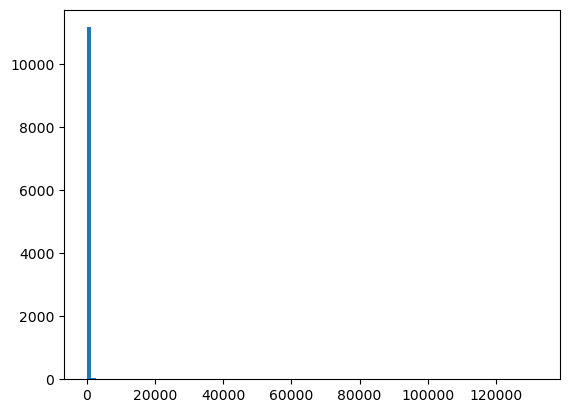

In [810]:
# Plot histogram of target variable
plt.hist(df['price'], bins=100)

In [811]:
# Get descriptive statistics
df['price'].describe()

count     11225.000000
mean        265.063875
std        1816.644937
min          25.000000
25%         125.000000
50%         181.000000
75%         270.000000
max      132137.000000
Name: price, dtype: float64

The histogram and descriptive statistics show that there must be outliers in the target feature. As the feature is not normally distributed, we use the mean absolute deviation to identify outliers and remove them from the data set.

In [812]:
# Reshape the target to make it 2D
y_2d = df['price'].values.reshape(-1,1)
# Fit the mean absoulte deviation to the target
mad = MAD().fit(y_2d)

# Extract the inlier/outlier labels
labels = mad.labels_
labels

array([0, 0, 0, ..., 0, 0, 0])

In [813]:
outliers_y_mad = df['price'].values[labels == 1]

num_outliers = len(outliers_y_mad)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(df['price']):.3f}")

The number of outliers: 586
Percentage of outliers: 0.052


(array([ 32., 119., 246., 268., 380., 317., 333., 399., 380., 421., 440.,
        532., 584., 475., 460., 477., 417., 464., 340., 344., 253., 230.,
        281., 186., 179., 182., 180., 217., 108., 119.,  93., 170.,  70.,
         77., 103.,  60., 111.,  76.,  47.,  56.,  45.,  63.,  35.,  37.,
         41.,  38.,  64.,  36.,  26.,  28.]),
 array([ 25.  ,  35.16,  45.32,  55.48,  65.64,  75.8 ,  85.96,  96.12,
        106.28, 116.44, 126.6 , 136.76, 146.92, 157.08, 167.24, 177.4 ,
        187.56, 197.72, 207.88, 218.04, 228.2 , 238.36, 248.52, 258.68,
        268.84, 279.  , 289.16, 299.32, 309.48, 319.64, 329.8 , 339.96,
        350.12, 360.28, 370.44, 380.6 , 390.76, 400.92, 411.08, 421.24,
        431.4 , 441.56, 451.72, 461.88, 472.04, 482.2 , 492.36, 502.52,
        512.68, 522.84, 533.  ]),
 <BarContainer object of 50 artists>)

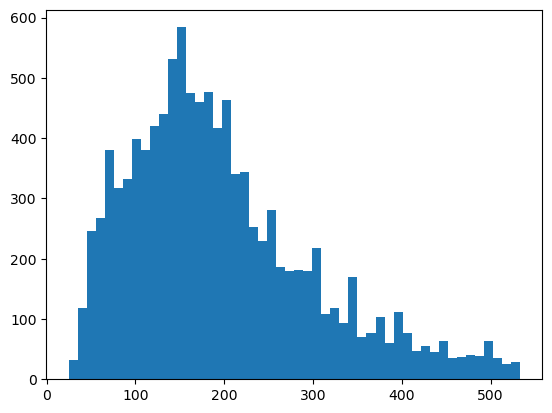

In [814]:
# Delete outliers from the dataset
df = df[labels==0]
# Plot a histogram of the price again
plt.hist(df['price'], bins=50)

The histogram looks much better now.

In [ ]:
## for best result with LGBM
import pickle
with open('df_reduced.pkl', 'wb') as file:
    pickle.dump(df, file)

## Phi-k test to reduce features

## Global correlation
The global correlation coefficient is a measure of the total correlation of one variable to all other variables in the dataset. It gives an indication of how well on variable can be modelled in terms of the other variables.

In [815]:
# Get numerical features
num_vars = df.select_dtypes(include=np.number).columns
# Calculate global correlation and labels
global_correlation, global_labels = df.global_phik(interval_cols=num_vars)
# Create corresponding dataframe
df_glob_corr = pd.DataFrame({'global_labels':global_labels, 'global_correlation':global_correlation[:,0]})
df_glob_corr = df_glob_corr.sort_values(by='global_correlation').reset_index(drop=True)
df_glob_corr

,global_labels,global_correlation
0,host_identity_verified,0.260980
1,host_verifications,0.369821
2,instant_bookable,0.374969
3,number_of_reviews,0.391737
4,host_since,0.394509
5,review_scores_mean,0.411304
6,host_is_superhost,0.471251
7,bathrooms,0.721493
8,price,0.736261
9,host_response_rate,0.741570


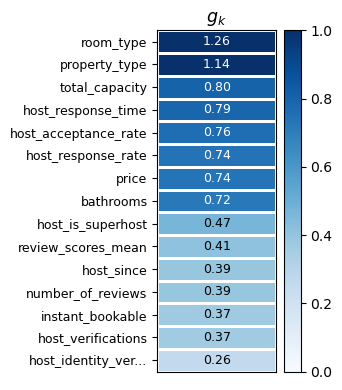

In [816]:
# Plot global correlation
plot_correlation_matrix(df_glob_corr.global_correlation.values.reshape(global_correlation.shape),
                        x_labels=[''], 
                        y_labels=df_glob_corr.global_labels.values.reshape(global_labels.shape), 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map='Blues', title=r'$g_k$',
                        fontsize_factor=.9)
plt.tight_layout()

The graph shows that the price of all features is only in the middle and therefore cannot be modelled very well.

## Plot ϕk-matrix
ϕk is a measure of the correlation between variables. Here we examine how the features are correlated and then look at the significances. In case of a strong correlation, i.e. close to 1 and a significance below and an alpha of 0.05, we consider dropping more features.

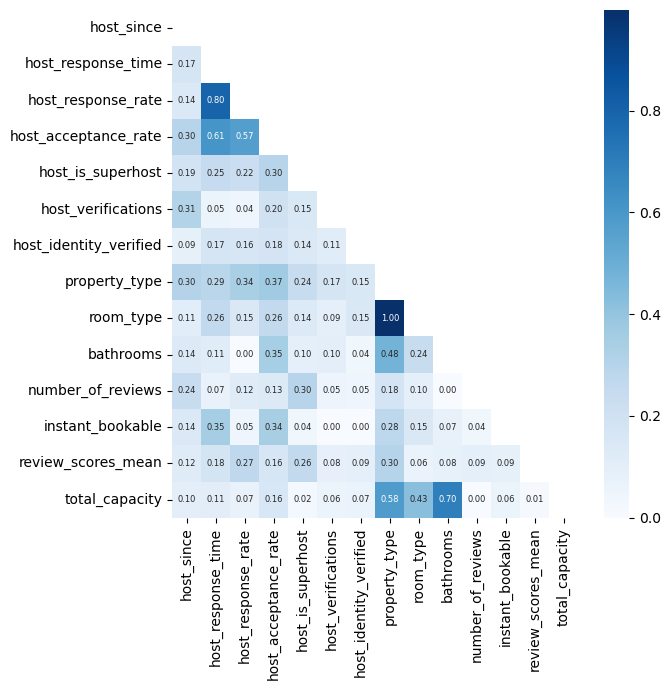

In [817]:
# Calculate phi-k matrix, numerical features are passed
phik_matrix = df.drop(columns='price').phik_matrix(interval_cols=num_vars)
# Create a mask over the diagonal for better readability
mask = np.triu(np.ones_like(phik_matrix, dtype=bool))
# Plot as heatmap
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(phik_matrix, mask=mask,
            annot=True,
            ax=ax,
            cmap='Blues',
            fmt=".2f",
            annot_kws={"size": 6})
plt.tight_layout()
plt.show()

* The ϕk-matrix shows that there is a strong correlation between property_type and room_type (0.94). As property_type is much more specific and is chosen by the host, 15 property types exist only once and even more only a few times.
* Furthermore, host_response_rate and host_response_time are highly correlated (0.8). Of the two, it seems to be more important whether a host responds, rather than how quickly.
* Total_capacity is the sum of accommodates, beds and bedrooms. It is logical that this correlates with bathrooms.

Before we drop any more features, let's also look at statistical significance.

In [818]:
# Drop property_type feature
# df.drop(columns=['property_type', 'host_response_time'], inplace=True)

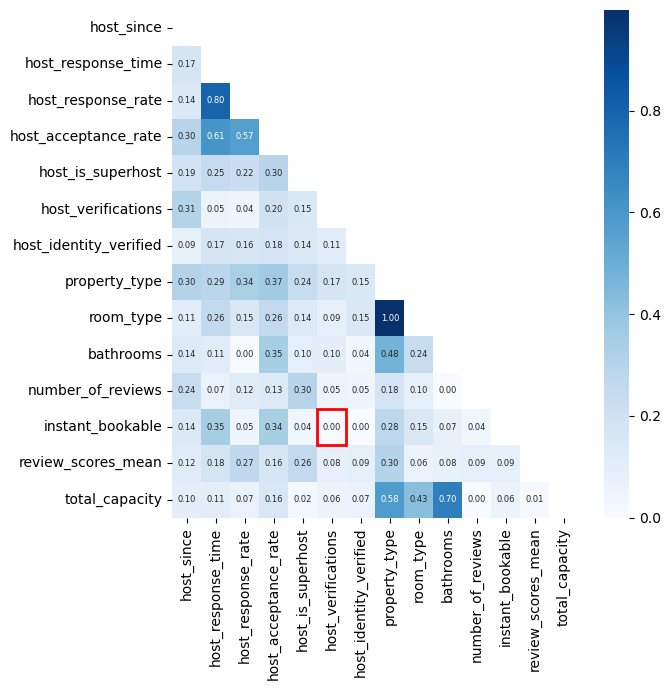

In [819]:
# Calculate significance matrix
significance_matrix = df.drop(columns='price').significance_matrix(interval_cols=num_vars)

# Create a boolean mask above the diagonal
mask_diagonal = np.triu(np.ones_like(phik_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(phik_matrix,
            mask=mask_diagonal,
            annot=True,
            ax=ax,
            cmap='Blues',
            fmt=".2f",
            annot_kws={"size": 6})
mask_diagonal = np.triu(np.ones_like(phik_matrix, dtype=bool))

# Create a boolean mask based on significance below an alpha of 0.05
mask_alpha = significance_matrix <= 0.05
combined_mask = mask_alpha & ~mask_diagonal

# Add a red border around the masked squares
for i in range(phik_matrix.shape[0]):
    for j in range(phik_matrix.shape[1]):
        if combined_mask.values[i, j]:
            rect = plt.Rectangle((j, i), 1, 1, edgecolor='red', linewidth=2, fill=False)
            ax.add_patch(rect)

plt.tight_layout()
plt.show()

The highlighted box indicates high significance with an alpha of 0.05. However, the features are not correlated, so they can be kept. Highly correlated features with low statistical significance, i.e. not highlighted in red, can also be retained.

## Plot phi-k with respect to target column only

In [ ]:
import phik
import numpy as np

phik_correlations = []
phik_significances = []

# Get integer and float columns
num_vars = [col for col in df.dtypes.index if df.dtypes[col].kind in ['i', 'f']]
y = df['price'].values
df_test = df.select_dtypes(include=[np.number, 'category']).drop(columns='price').reset_index(drop=True)

for col in df_test:
    x = df[col]
    if col in num_vars:    
        phik_correlations.append(phik.phik_from_array(x, y, [col]))
        phik_significances.append(phik.significance.significance_from_array(x, y, [col])[0])
    
    else:
        print(col)
        phik_correlations.append(phik.phik_from_array(x.values, y))
        phik_significances.append(phik.significance.significance_from_array(x, y)[0])

In [ ]:
df_phik = pd.DataFrame({'phik':phik_correlations, 'significance': phik_significances},
                       index=df.select_dtypes(include=[np.number, 'category']).drop(columns='price').columns)

df_phik.sort_values(by='phik', ascending=False, inplace=True)
df_phik.iloc[1:].plot.bar(subplots=True)

## Visually inspect skew of features

In [820]:
numeric_columns = df.select_dtypes(include=np.number).columns
# Get non-binary numerical features
non_binary_columns = [col for col in numeric_columns if df[col].nunique() > 2]
non_binary_columns

['host_since',
 'host_response_rate',
 'host_acceptance_rate',
 'bathrooms',
 'price',
 'number_of_reviews',
 'review_scores_mean',
 'total_capacity']

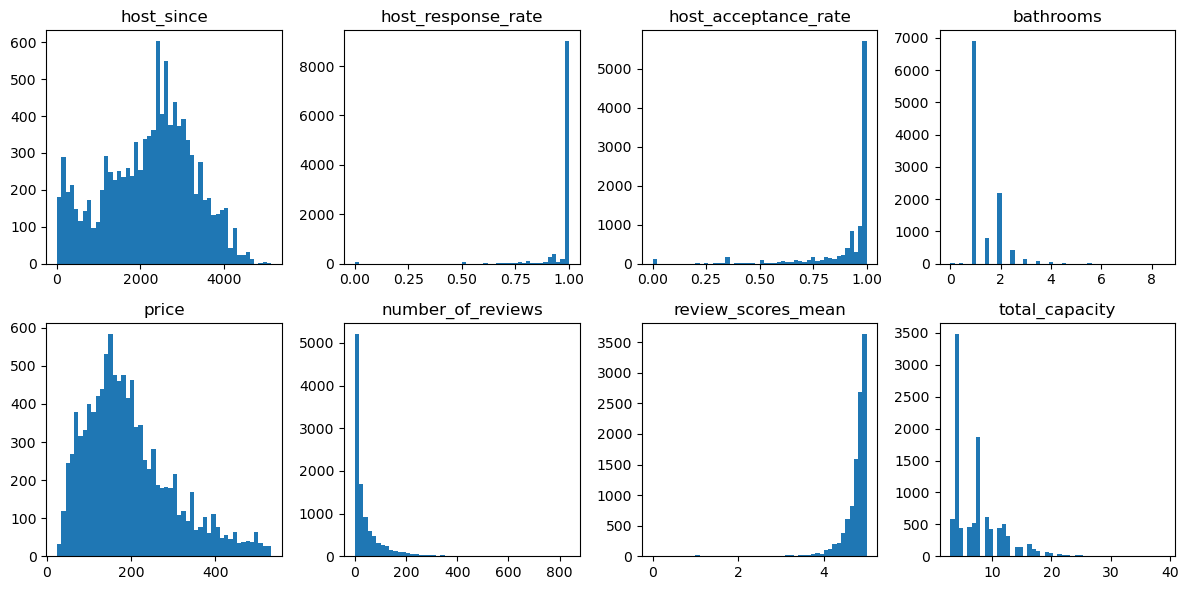

In [821]:
len_num_cols = len(non_binary_columns)
cols = 4
rows = (len_num_cols - 1) // cols + 1

fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

for i, col in enumerate(non_binary_columns):
    ii, ij = i // cols, i % cols
    ax[ii, ij].hist(df[col], bins=50)
    ax[ii, ij].set_title(col)

# Remove empty subplots
if len_num_cols % cols != 0:
    for j in range(len_num_cols % cols, cols):
        fig.delaxes(ax[rows - 1, j])

plt.tight_layout()
plt.show()

## Yeo-Johnson / Box-Cox transform skewed features
Box-Cox only works with positive input values, whereas Yeo-Johnson can work with negative values. 

In [822]:
# Inspect skewness of non-binary numeric features
df[non_binary_columns].skew()

host_since             -0.233217
host_response_rate     -6.014134
host_acceptance_rate   -2.875155
bathrooms               2.542287
price                   0.941920
number_of_reviews       3.357325
review_scores_mean     -5.705707
total_capacity          1.780017
dtype: float64

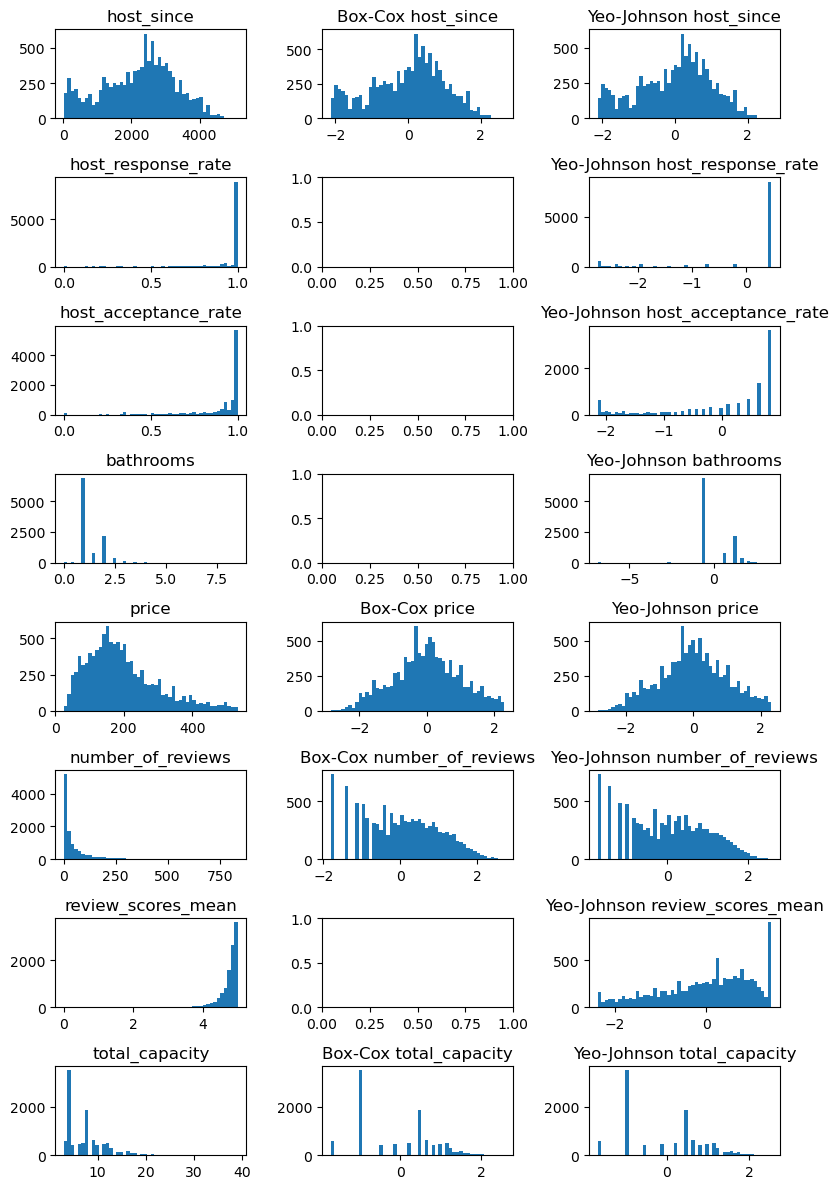

In [823]:
pt = PowerTransformer()

fig, ax = plt.subplots(8, 3, figsize=(8, 12))

df_skew = pd.DataFrame({'skew': df[non_binary_columns].skew()})

for i, col in enumerate(non_binary_columns):
    ax[i, 0].hist(df[col], bins=50)
    ax[i, 0].set_title(col)

    # Transform with Box-Cox for purely positive features
    if all(x > 0 for x in df[col]):
        pt.set_params(method='box-cox')

        data = pt.fit_transform(df[col].values.reshape(-1, 1))
        df_skew.loc[col, 'skew_box_cox'] = skew(data)

        ax[i, 1].hist(data, bins=50)
        ax[i, 1].set_title('Box-Cox '+col)

    # Transform with Yeo-Johnson
    pt.set_params(method='yeo-johnson')

    data = pt.fit_transform(df[col].values.reshape(-1, 1))
    df_skew.loc[col, 'skew_yeo_johnson'] = skew(data)

    ax[i, 2].hist(data, bins=50)
    ax[i, 2].set_title('Yeo-Johnson '+col)

# Remove empty subplots
if len_num_cols % cols != 0:
    for j in range(len_num_cols % cols, cols):
        fig.delaxes(ax[rows - 1, j])

plt.tight_layout()
plt.show()


In [824]:
df_skew

,skew,skew_box_cox,skew_yeo_johnson
host_since,-0.233217,-0.291363,-0.290561
host_response_rate,-6.014134,NaN,-1.939150
host_acceptance_rate,-2.875155,NaN,-0.976934
bathrooms,2.542287,NaN,-0.247797
price,0.941920,-0.016439,-0.016084
number_of_reviews,3.357325,-0.012746,0.017273
review_scores_mean,-5.705707,NaN,-0.535644
total_capacity,1.780017,0.075776,0.095134


In [825]:
df_skew.loc[:, 'box_cox_better'] = (np.abs(df_skew['skew'])-np.abs(0-df_skew.skew_box_cox))>0
df_skew.loc[:, 'yeo_johnson_better'] = (np.abs(df_skew['skew'])-np.abs(0-df_skew.skew_yeo_johnson))>0
df_skew

,skew,skew_box_cox,skew_yeo_johnson,box_cox_better,yeo_johnson_better
host_since,-0.233217,-0.291363,-0.290561,False,False
host_response_rate,-6.014134,NaN,-1.939150,False,True
host_acceptance_rate,-2.875155,NaN,-0.976934,False,True
bathrooms,2.542287,NaN,-0.247797,False,True
price,0.941920,-0.016439,-0.016084,True,True
number_of_reviews,3.357325,-0.012746,0.017273,True,True
review_scores_mean,-5.705707,NaN,-0.535644,False,True
total_capacity,1.780017,0.075776,0.095134,True,True


In all cases except the *host_since* feature, the power transformation reduces the skewness of the data. In some cases the Box-Cox methods give slightly better skew than Yeo-Johnson. Let's fit_transform the data in the data frame.

In [826]:
cols_yeo_johnson = ['host_response_rate', 'host_acceptance_rate', 'bathrooms', 'price', 'review_scores_mean']
cols_box_cox = ['number_of_reviews', 'total_capacity']

for col in cols_yeo_johnson:
    pt.set_params(method='yeo-johnson')
    df[col] = pt.fit_transform(df[col].values.reshape(-1,1))

for col in cols_box_cox:
    pt.set_params(method='box-cox')
    df[col] = pt.fit_transform(df[col].values.reshape(-1,1))

## Dump dataframe as pickle

In [827]:
with open('df_lates.pkl', 'wb') as f:
    pickle.dump(df, f)